# Práctica 1 - Self-Organising Maps - COLORES
## Preparación de entorno
#### Importar librerías de código

In [1]:
import numpy as np
from math import exp
import pandas as pd
import re
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#### Dataset que se va a utilizar para el entrenamiento

In [2]:
# Código para obtener el Dataset que se va a usar en el entrenamiento
valor_min = 0
valor_max = 256
valores_color = 100
num_colores = 3

datos = np.random.randint(valor_min, valor_max, (valores_color, num_colores))

print(datos)

[[183  39 221]
 [226 245 164]
 [243 180  58]
 [139 149 246]
 [236  37 160]
 [206  68 138]
 [237  27  39]
 [214 245 147]
 [ 95 200 225]
 [ 13  51  24]
 [129   5 206]
 [236  73  49]
 [197 240  79]
 [231 139  14]
 [207 235  56]
 [127 192 173]
 [169 205 114]
 [ 77  89  33]
 [  4 148 160]
 [119 194 209]
 [125 142  25]
 [ 29   6 233]
 [202 223 174]
 [ 60 143 142]
 [155  87  75]
 [ 97  74  51]
 [163   0 209]
 [158  24 235]
 [246  39  93]
 [ 52 156 148]
 [ 22 197 206]
 [207 229  83]
 [ 61   0   1]
 [ 28  68  13]
 [194  32  54]
 [142 193 142]
 [ 49 213 225]
 [144 225  27]
 [ 62 131  88]
 [ 68  84 142]
 [ 11   8 163]
 [170 167  22]
 [ 35 145 196]
 [217  74  97]
 [159 181  83]
 [ 97 200 123]
 [ 59 195 242]
 [ 32 176 190]
 [  2 158 157]
 [ 38 124  78]
 [176 171 216]
 [123  47 182]
 [ 84  79 232]
 [ 97 192  23]
 [120 101  89]
 [ 35 137  23]
 [ 44 162  68]
 [185 147   2]
 [ 25 131 151]
 [187 210  45]
 [152 147  80]
 [198 144  41]
 [157  27 147]
 [142 235 132]
 [165 171 162]
 [208 254 218]
 [173  37 

## SOM Setup
#### Variables definidas por el alumno

In [3]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones, learning rate y la normalización de los datos
lado_mapa = 40
periodo = 5000
learning_rate = 0.07
normalizar_datos = True

#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [4]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar.
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = len(datos)
num_datos = len(datos[0])

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario = lado_mapa//2

# Crea una matriz de pesos con valores random entre 0 y 1.
dimensiones_matriz_pesos = (lado_mapa, lado_mapa, num_datos)
matriz_pesos = np.random.random((lado_mapa,lado_mapa,num_entradas))
matriz_pesos_entrenados = matriz_pesos.copy()


#### Funciones para entrenar/clasificar

In [5]:
#Función para calcular la bmu
def calcular_bmu(patron_entrada, m_pesos, m):
    """
    Encuentra la BMU para un patrón de entrada.
    Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
    Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
    """
    distancias = np.linalg.norm(m_pesos - patron_entrada[np.newaxis, :], axis=2)
    bmu_idx = np.unravel_index(np.argmin(distancias, axis=None), distancias.shape)
    bmu = m_pesos[bmu_idx[0], bmu_idx[1]]
    return bmu, bmu_idx


In [6]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
def variacion_learning_rate(lr_inicial, i, n_iteraciones):

   #Calcula el factor de descenso
   decay=i/n_iteraciones

   #Calculo el nuevo learning rate
   nuevo_lr=lr_inicial*(1-decay)

   #Return del descenso del learning rate (coeficiente de aprendizaje)
   return nuevo_lr



In [7]:
# Función para calcular el descenso del vecindario (v)
def variacion_vecindario(vecindario_inicial, i, n_iteraciones):
    # Calcula el factor de descenso exponencial
    tasa_de_descenso = i / n_iteraciones
    nuevo_vecindario = vecindario_inicial * exp(-tasa_de_descenso)
    return nuevo_vecindario

In [8]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU**2 / (2*vecindario_actual**2))

#### Funciones para dibujar la salida de la red

In [9]:
# Función para pintar una matriz de valores como colores RGB
def pintar_mapa(matriz_valores):
    fig = plt.figure()

    # Establece ejes
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, matriz_pesos.shape[0]+1))
    ax.set_ylim((0, matriz_pesos.shape[1]+1))
    ax.set_title('Self-Organising Map después de %d iteraciones' % periodo)

    # Dibuja los rectángulos de color RGB
    for x in range(1, matriz_valores.shape[0] + 1):
        for y in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                         facecolor=matriz_valores[x-1,y-1,:],
                         edgecolor='none'))
    plt.show()

## SOM Entrenamiento

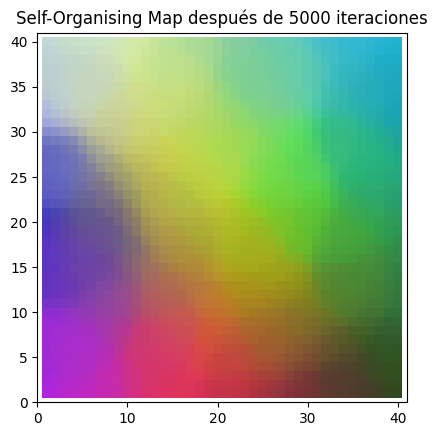

In [10]:
# Funciones definidas por el alumno
# Entrenamiento del SOM
num_entradas = len(datos)
num_datos = len(datos[0])
vecindario = lado_mapa // 2

#En el caso de que se haya escogido la normalización de los datos se ejecutara la condición
if normalizar_datos:
    max_valor = np.amax(datos)
    datos = datos / max_valor

dimensiones_matriz_pesos = (lado_mapa, lado_mapa, num_datos)
matriz_pesos = np.random.random(dimensiones_matriz_pesos)
matriz_pesos_sin_entrenar = matriz_pesos.copy()

for i in range(periodo):
    patron = datos[np.random.randint(0, num_entradas)]
    bmu, bmu_idx = calcular_bmu(patron, matriz_pesos, num_datos)
    eta = variacion_learning_rate(learning_rate, i, periodo)
    v = variacion_vecindario(vecindario, i, periodo)

    for x in range(lado_mapa):
        for y in range(lado_mapa):
            dist_x, dist_y = np.abs(bmu_idx[0] - x), np.abs(bmu_idx[1] - y)
            distancia_a_bmu = np.sqrt(dist_x**2 + dist_y**2)
            if distancia_a_bmu <= v:
                ajuste = eta * (patron - matriz_pesos[x][y])
                matriz_pesos[x][y] += ajuste


# Pintar el mapa después de entrenar el SOM
pintar_mapa(matriz_pesos)


## SOM Clasificación

Coordenadas de la BMU para el patrón actual: 0 0
Coordenadas de la BMU para el patrón actual: 10 39
Coordenadas de la BMU para el patrón actual: 14 26
Coordenadas de la BMU para el patrón actual: 0 30
Coordenadas de la BMU para el patrón actual: 9 0
Coordenadas de la BMU para el patrón actual: 9 4
Coordenadas de la BMU para el patrón actual: 17 0
Coordenadas de la BMU para el patrón actual: 10 36
Coordenadas de la BMU para el patrón actual: 29 39
Coordenadas de la BMU para el patrón actual: 39 0
Coordenadas de la BMU para el patrón actual: 0 9
Coordenadas de la BMU para el patrón actual: 18 6
Coordenadas de la BMU para el patrón actual: 16 27
Coordenadas de la BMU para el patrón actual: 20 10
Coordenadas de la BMU para el patrón actual: 16 26
Coordenadas de la BMU para el patrón actual: 24 39
Coordenadas de la BMU para el patrón actual: 19 32
Coordenadas de la BMU para el patrón actual: 34 6
Coordenadas de la BMU para el patrón actual: 39 29
Coordenadas de la BMU para el patrón actual:

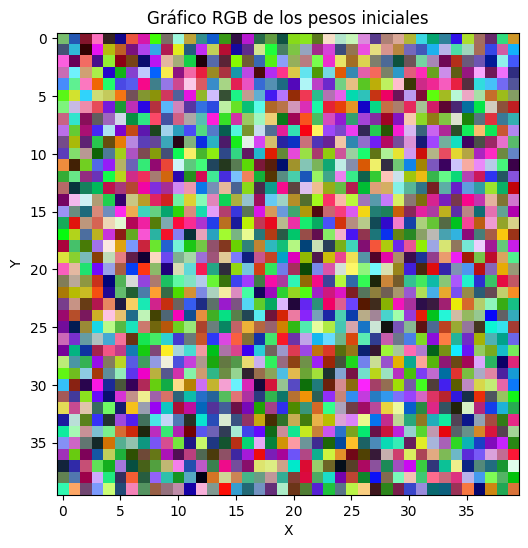

In [11]:
# Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada
#Matriz mapa_clasificacion incializada a 0, con las mismas dimensiones que la matriz de pesos
mapa_clasificacion=np.zeros_like(matriz_pesos)

#Matriz mapa_activaciones (que es bidimensional)
mapa_activaciones=np.zeros((lado_mapa,lado_mapa))

#Matriz del mapa de distancias
mapa_distancias = np.zeros((lado_mapa, lado_mapa))

#Recorro todo el dataset de entrenamiento
num_clases=0
for patron in datos:

    # Calcular la BMU para el patrón actual
    bmu, bmu_idx = calcular_bmu(patron, matriz_pesos, num_datos)
    x_bmu, y_bmu = bmu_idx

    # Imprimo las coordenadas (x, y) de la BMU para cada patrón de prueba
    print("Coordenadas de la BMU para el patrón actual:", x_bmu, y_bmu)

    # Actualizar el mapa de clasificación con el patrón actual
    mapa_clasificacion[x_bmu, y_bmu] = patron

    # Incrementar el conteo de activaciones para la BMU
    mapa_activaciones[x_bmu, y_bmu] += 1

    # Calcular la distancia media de todos los patrones de la clase con su vector de pesos
    if mapa_activaciones[x_bmu, y_bmu] > 0:
        distancia_media = np.linalg.norm(matriz_pesos[x_bmu, y_bmu] - patron)
        mapa_distancias[x_bmu, y_bmu] = distancia_media

    # Calcular el número de clases
    num_clases = len(np.unique(mapa_clasificacion))


# Calcular el Error Topológico del mapa
error_topologico = (np.sum(mapa_activaciones > 0) / (lado_mapa * lado_mapa))
def calcular_error_cuantificacion(datos, matriz_pesos_entrenados):
    num_patrones = len(datos)
    error_cuantificacion = 0.0

    for patron in datos:
        bmu, _ = calcular_bmu(patron, matriz_pesos_entrenados, len(patron))
        error_cuantificacion += np.linalg.norm(patron - bmu)

    error_cuantificacion /= num_patrones
    return error_cuantificacion

# Calcular el error de cuantificación
error_cuantificacion = calcular_error_cuantificacion(datos, matriz_pesos)
print("Error de Cuantificación:", error_cuantificacion)


#Imprimir Error Topologico
print(f'Error Topologico {error_topologico}')


# 1. Gráfico RGB de los pesos iniciales
plt.figure(figsize=(8, 6))
plt.imshow(matriz_pesos_sin_entrenar)
plt.title('Gráfico RGB de los pesos iniciales')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


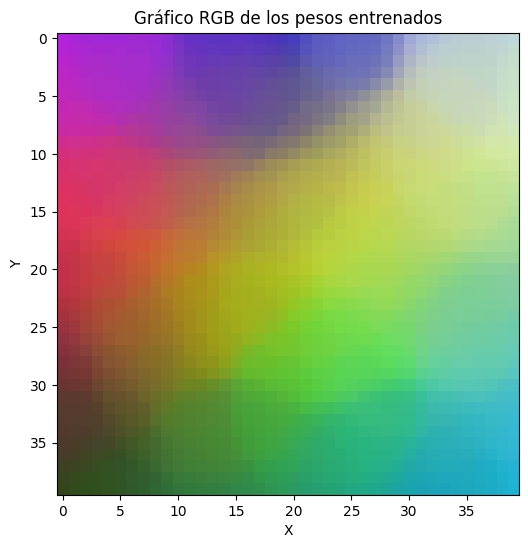

In [12]:
# 2. Gráfico RGB de los pesos entrenados
plt.figure(figsize=(8, 6))
plt.imshow(matriz_pesos)
plt.title('Gráfico RGB de los pesos entrenados')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


Número de clases: 170


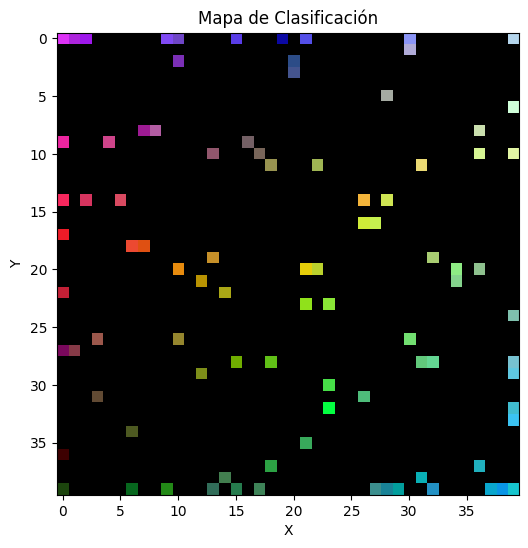

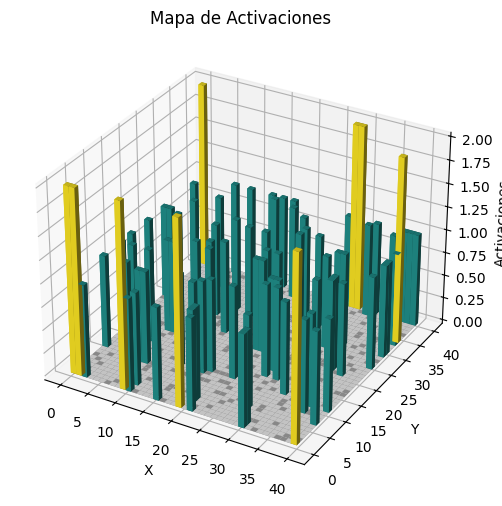

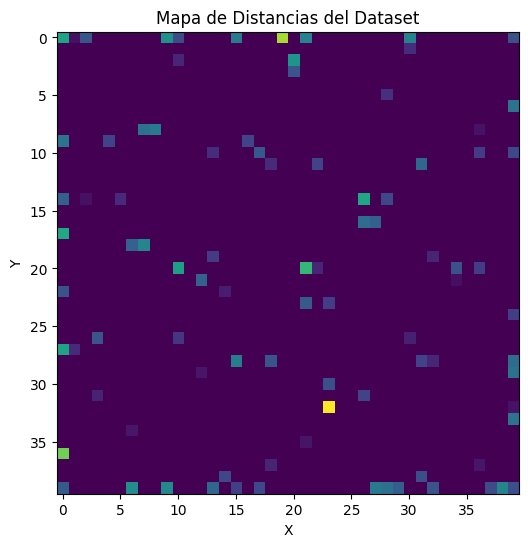

Error de Cuantificación: 0.10699159532986802
Error Topológico: 0.056875


In [13]:
# 3. Número de clases
num_clases = len(np.unique(mapa_clasificacion))
print(f"Número de clases: {num_clases}")

# 4. Mapa de clasificación (gráfico RGB)
plt.figure(figsize=(8, 6))
plt.imshow(mapa_clasificacion)
plt.title('Mapa de Clasificación')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Normalizar el mapa de activaciones y aplicar el colormap
activaciones_normalizadas = mapa_activaciones / np.max(mapa_activaciones)
colores = plt.cm.viridis(activaciones_normalizadas)

# Crear la figura y los ejes
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Coordenadas para las barras del histograma 3D
X, Y = np.meshgrid(np.arange(lado_mapa), np.arange(lado_mapa))

# Tamaño de las barras y coordenadas z
dx = dy = 1
dz = mapa_activaciones.ravel()

# Aplanar la matriz de colores para que coincida con dz
colores_aplanados = colores.reshape(-1, 4)

# Asignar color blanco a las activaciones cero
colores_aplanados[dz == 0, :] = [1, 1, 1, 1]  # RGBA para blanco

# Agregar las barras con colores mapeados
ax.bar3d(X.ravel(), Y.ravel(), dz * 0, dx, dy, dz, color=colores_aplanados)

# Configuraciones adicionales de los ejes y el título
ax.set_title('Mapa de Activaciones')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Activaciones')

plt.show()


# 6. Mapa de distancias del dataset
plt.figure(figsize=(8, 6))
plt.imshow(mapa_distancias)
plt.title('Mapa de Distancias del Dataset')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# 7. Distancia Media (Error de Cuantificacion y Error Topologico)
print("Error de Cuantificación:", error_cuantificacion)
print("Error Topológico:", error_topologico)

## SOM Prueba

Ubicación de la BMU para el patrón 1: (6, 39)
Ubicación de la BMU para el patrón 2: (17, 0)
Ubicación de la BMU para el patrón 3: (31, 21)
Ubicación de la BMU para el patrón 4: (0, 19)
Ubicación de la BMU para el patrón 5: (19, 22)
Ubicación de la BMU para el patrón 6: (0, 0)
Ubicación de la BMU para el patrón 7: (38, 39)
Ubicación de la BMU para el patrón 8: (39, 0)


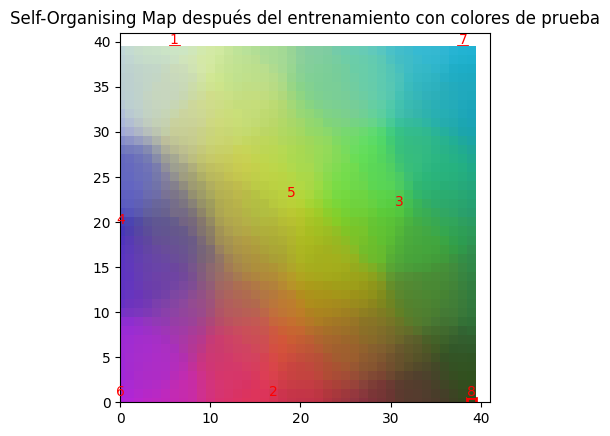

In [14]:
# Función para clasificar un nuevo patrón utilizando la BMU
def clasificar_nuevo_patron(nuevo_patron, matriz_pesos_entrenados):
    bmu, bmu_idx = calcular_bmu(nuevo_patron, matriz_pesos_entrenados, len(nuevo_patron))
    return bmu, bmu_idx

# Función para pintar dentro del mapa los patrones clasificados
def pintar_mapa_con_patrones(matriz_valores, bmu_idx_patrones):
    fig = plt.figure()

    # Establecer ejes
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, matriz_valores.shape[0]+1))
    ax.set_ylim((0, matriz_valores.shape[1]+1))
    ax.set_title('Self-Organising Map después del entrenamiento con colores de prueba')

    # Dibujar los rectángulos de color RGB para cada patrón
    for i, bmu_idx_nuevo_patron in enumerate(bmu_idx_patrones):
        for x in range(matriz_valores.shape[0]):
            for y in range(matriz_valores.shape[1]):
                if (x, y) == bmu_idx_nuevo_patron:
                    # Resaltar el patrón con un marcador o etiqueta
                    ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1, facecolor=matriz_valores[x,y,:], edgecolor='red', linewidth=2))
                    # Añadir las coordenadas para escribir el texto del número de patrón
                    ax.text(x, y+1.2, str(i+1), color='red', ha='center', va='center')
                else:
                    ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1, facecolor=matriz_valores[x,y,:], edgecolor='none'))

    plt.show()

# Valores RGB que quieres clasificar
valores_rgb = [[255, 255, 255], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [0, 0, 0]]

# Normalizar los valores RGB
valores_rgb_normalizados = np.array(valores_rgb) / 255.0

# Lista para almacenar las ubicaciones de las BMUs de cada patrón
bmu_idx_patrones = []

# Clasificar cada uno de los valores RGB y almacenar las ubicaciones de las BMUs
for i, rgb in enumerate(valores_rgb_normalizados):
    bmu_nuevo_patron, bmu_idx_nuevo_patron = clasificar_nuevo_patron(rgb, matriz_pesos)
    bmu_idx_patrones.append(bmu_idx_nuevo_patron)
    print(f"Ubicación de la BMU para el patrón {i+1}:", bmu_idx_nuevo_patron)

# Pintar el mapa con todos los patrones clasificados
pintar_mapa_con_patrones(matriz_pesos, bmu_idx_patrones)


Nuevo patrón aleatorio generado: [217 235 181]
Ubicación de la BMU para el nuevo patrón: (8, 38)


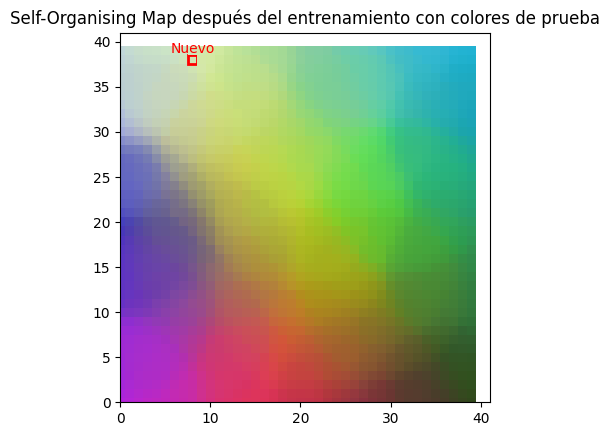

In [15]:
# Clasificar un nuevo patrón utilizando la BMU
def clasificar_nuevo_patron(nuevo_patron, matriz_pesos_entrenados):
    bmu, bmu_idx = calcular_bmu(nuevo_patron, matriz_pesos_entrenados, len(nuevo_patron))
    return bmu, bmu_idx

# Generar un nuevo patrón de color aleatorio
#Se genera un color aleatorio para ver si la red esta bien entrenada

nuevo_patron = np.random.randint(0, 256, size=(3,))
print("Nuevo patrón aleatorio generado:", nuevo_patron)

# Normalizar el nuevo patrón
nuevo_patron_normalizado = nuevo_patron / 255.0

# Clasificar el nuevo patrón utilizando la red entrenada
bmu_nuevo_patron, bmu_idx_nuevo_patron = clasificar_nuevo_patron(nuevo_patron_normalizado, matriz_pesos)
# Mostrar la ubicación de la BMU para el nuevo patrón
print("Ubicación de la BMU para el nuevo patrón:", bmu_idx_nuevo_patron)


# Pintar dentro del mapa el color aleatorio para ver si lo clasifica bien
def pintar_mapa_con_nuevo_patron(matriz_valores, bmu_idx_nuevo_patron):
    fig = plt.figure()

    # Establecer ejes
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, matriz_valores.shape[0]+1))
    ax.set_ylim((0, matriz_valores.shape[1]+1))
    ax.set_title('Self-Organising Map después del entrenamiento con colores de prueba')

    # Dibujar los rectángulos de color RGB
    for x in range(matriz_valores.shape[0]):
        for y in range(matriz_valores.shape[1]):
            if (x, y) == bmu_idx_nuevo_patron:
                # Resaltar el nuevo patrón con un marcador o etiqueta
                ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1, facecolor=matriz_valores[x,y,:], edgecolor='red', linewidth=2))
                #Añado las coordenadas para escribir el texto nuevo
                ax.text(x, y+1.2, 'Nuevo', color='red', ha='center', va='center')
            else:
                ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1, facecolor=matriz_valores[x,y,:], edgecolor='none'))

    plt.show()
# Pintar el mapa después de entrenar el SOM con el nuevo patrón resaltado
pintar_mapa_con_nuevo_patron(matriz_pesos, bmu_idx_nuevo_patron)
